# Telstra Network Disruptions

In [2]:
########
# data #
########

datadir = '/home/kcavagnolo/ml_fun/telstra/data/'
files = sorted(glob.glob(datadir+'*.csv'))

##############
# basic libs #
##############

from tqdm import *
import warnings
import os, sys, time, datetime, json, string, glob, re
warnings.filterwarnings('ignore')

############
# plumbing #
############

from sqlalchemy import create_engine
from collections import OrderedDict
import urllib2, requests, operator, hashlib, uuid

###########
# science #
###########

from math import radians, cos, sin, asin, sqrt
from scipy import integrate, stats
from scipy.spatial import distance
import numpy as np
import pandas as pd
import pymc3 as pm
import theano as thno
import theano.tensor as T

#################
# visualization #
#################

# plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='pearl')
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'), api_key=os.environ.get('PLOTLY_APIKEY'))

# matplotlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# seaborn
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

#graphistry
import graphistry
graphistry.register(key=os.environ.get('GRAPHISTRY_APIKEY'))

## What's the problem?

* Informal: using Telstra's service logs, the task is to predict the severity of a network disruption.

* Describe the problem formally, e.g.
    * Task (T): For a specific time and location, classify network fault severity as 0 == no faults, 1 == few faults, 2 == many faults. Fault severity is a measurement of actual reported faults from users of the network and is the target variable.
    * Experience (E): Each row in the train/test data represents a location and a time point. They are identified by the "id" column, which is the key "id" used in the other data files (event_type, resource_type, severity_type, log_feature) that contain features extracted from log files and other sources. Note that severity_type:
        * Is a categorical feature extracted from the log files
        * "Often" (**when is it not?**) the type of the warning message coming from the log files
        * Does not have an ordering
    * Performance (P): Classification accuracy, the number of fault events predicted correctly (a set of predicted probabilities one for every fault severity mus be given) out of all faults considered as a percentage.

* Assumptions:
    * All given features will matter to the model.
    * The clustering in time and location matter to the model, but may be mutually exclusive.
    * The volume of faults may not matter to the model.
    * Systemic long duration, low-volume correlated faults could be hiding in data.

* Similar problems:
    * Airline loyalty and medallion class problem
    * Anomaly detection, e.g. [Twitter's R package](https://github.com/nicolasmiller/pyculiarity)

## How should I solve this problem?
* Brainstorm! Literally type everything as a stream of consciousness (coffee helps here)

These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts.

* Describe how to solve problem manually
* What data do I have?
* What data do I need?
* What data I **don't** need?
* What do I know the least about in the solution process above?
    * knowledge gap 1
    * knowledge gap 2
* What am I concerned is incorrect in above solution? Find an expert online and ask them about these items
    * concern 1
    * concern 2

# Data Preparation

## ETL

In [143]:
# go through each file and tell me what's in it
for f in files:
    df = pd.read_csv(f)
    cols = df.columns.tolist()
    obs = df.shape[0]
    print '{:15} {:s}'.format('Filename:', f)
    print '{:15} {:d}'.format('Observations:', obs)
    for c in cols:
        uflag = ""
        nflag = ""
        uni = len(pd.unique(df[c].ravel()))
        nulls = np.count_nonzero(df[c].isnull())
        if obs != uni:
            uflag = '*MULTIPLE VALS PER KEY*'
        if nulls >0 :
            nflag = '*NULLS IN COL*'
        print '{:15} {:d} {:20} {:20}'.format(c, uni, uflag, nflag)
    print '\n'

Filename:       /home/kcavagnolo/ml_fun/telstra/data/event_type.csv
Observations:   31170
id              18552 *MULTIPLE VALS PER KEY*                     
event_type      53 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/telstra/data/log_feature.csv
Observations:   58671
id              18552 *MULTIPLE VALS PER KEY*                     
log_feature     386 *MULTIPLE VALS PER KEY*                     
volume          9 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/telstra/data/resource_type.csv
Observations:   21076
id              18552 *MULTIPLE VALS PER KEY*                     
resource_type   10 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/telstra/data/severity_type.csv
Observations:   18552
id              18552                                          
severity_type   5 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/t

* Column names look fine, don't need to clean those
* No nulls, hooray
* Looks like each ID has only one severity type and multiple event types| log features| resource types:

For example, in the training set, consider ID 10005:

|id| item | code | sev/vol
|:-|:-|:-:|:-:
|10005 | location |802 | 0
|10005|severity_type |1|
|10005|event_type |11|
|10005|event_type |13|
|10005|event_type |14|
|10005|log_feature| 345|1
|10005|log_feature| 54|1
|10005|resource_type |4|
|10005|resource_type |6|
|10005|resource_type |8|

Transposing would be

|id|loc|sev|evt|fea|res
|-|
|10005|{802:0}|1|[11,13,14]|{54:1,345:1}|[4,6,8]

For a single id, the coding can't be a list, so one hot encode every type? How many are we talking?
* 53 event types (binary)
* 386 log features (continuous)
* 10 resource types (binary)

That's 449 features. Regardless, need to join all this data together. It's all categorical data (code_n is y/n), except for the log features which has a volume. What's the distribution and can data be re-binned into fewer values?

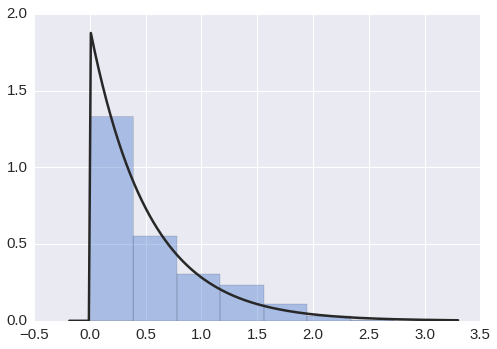

In [147]:
# one time analysis to re-bin volunme data
df = pd.read_csv('/home/kcavagnolo/ml_fun/telstra/data/log_feature_volume.csv', index_col=0)
x = np.log10(df['volume'][(df.volume > 0)].values)
sns.distplot(x, bins=8, kde=False, fit=stats.expon)

# grab the bins in log space use the built-in Freedman-Diaconis rule
hist, bins = np.histogram(x, bins=8)

# assign each volume to a bin
inds = np.digitize(x, bins)

# add this to the df
df['volume'] = inds

# re-save
df.to_csv('/home/kcavagnolo/ml_fun/telstra/data/log_feature_class.csv',index=False)

The event sev, evt, and res values can be coded into categoricals of 0/1 (one hot encode)

In [297]:
# set the train set as the master join
df = pd.read_csv(files[5], index_col=0)
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
df_final = df

# only need first three files
nfiles = [files[0], files[2], files[3]]

# iterate over files
for f in nfiles:
    key = f.replace(datadir, '')[:3]
    df = pd.read_csv(f, index_col=0)
    for c in df.columns:
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
    dfv = pd.get_dummies(df).groupby(df.index).sum()
    df_final = df_final.join(dfv)

In [298]:
files

['/home/kcavagnolo/ml_fun/telstra/data/event_type.csv',
 '/home/kcavagnolo/ml_fun/telstra/data/log_feature.csv',
 '/home/kcavagnolo/ml_fun/telstra/data/resource_type.csv',
 '/home/kcavagnolo/ml_fun/telstra/data/severity_type.csv',
 '/home/kcavagnolo/ml_fun/telstra/data/test.csv',
 '/home/kcavagnolo/ml_fun/telstra/data/train.csv']

In [299]:
# build a matrix of lfea that has values of not 0/1 but the volume
df = pd.read_csv(files[1])
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))

# keep track of unique values
codes = {}
vals = pd.unique(df['id'].values.ravel())
num = max(pd.unique(df['log_feature'].values.ravel().astype(int)))+1
cnames = ['lfea'+str(x) for x in range(1,num)]

# iterate over id's
for id in vals:
    x = [0]*num
    for i in df['log_feature'].loc[df['id'] == id].tolist():
        i = int(i)
        x[i] = int(df['volume'][(df['id'] == id) & (df['log_feature'] == str(i))])
    codes[id] = x

# dump to dataframe
df = pd.DataFrame.from_dict(codes, orient='index')
df = df.drop(0, 1)
df.columns = cnames

In [300]:
# gut check
test = df_final.join(df)
dft = test.T
x = dft.loc[:, 10005] > 0
x[x].index

Index([u'location', u'event_type_11', u'event_type_13', u'event_type_14',
       u'resource_type_4', u'resource_type_6', u'resource_type_8',
       u'severity_type_1', u'lfea54', u'lfea345'],
      dtype='object')

Yep, those are all correct. So this is a good dataset now.

In [ ]:
df_final = df_final.join(df)

In [305]:
print df_final.shape
df_final.head()

(7381, 456)


,location,fault_severity,event_type_1,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,event_type_17,...,lfea377,lfea378,lfea379,lfea380,lfea381,lfea382,lfea383,lfea384,lfea385,lfea386
id,,,,,,,,,,,,,,,,,,,,,
14121,118,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9320,91,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14394,152,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8218,931,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
14804,120,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [306]:
# save to lrzipped hdf5 for easier loading later
df_final.to_hdf(datadir + 'features.h5', 'df')
!lrzip -zf /home/kcavagnolo/ml_fun/telstra/data/features.h5
!rm -f /home/kcavagnolo/ml_fun/telstra/data/features.h5

Output filename is: /home/kcavagnolo/ml_fun/telstra/data/features.h5.lrz
/home/kcavagnolo/ml_fun/telstra/data/features.h5 - Compression Ratio: 1614.656. Average Compression Speed:  6.837MB/s.
Total time: 00:01:25.59


# Reload the hdf5 file -- better starting point for future analysis.

In [5]:
#!lrunzip -f /home/kcavagnolo/ml_fun/telstra/data/features.h5.lrz
store = pd.HDFStore(datadir+'features.h5')
print store

<class 'pandas.io.pytables.HDFStore'>
File path: /home/kcavagnolo/ml_fun/telstra/data/features.h5
/df            frame        (shape->[7381,456])


In [6]:
df = store['df']
df.sort_index(inplace=True)
df.columns

Index([u'location', u'fault_severity', u'event_type_1', u'event_type_10',
       u'event_type_11', u'event_type_12', u'event_type_13', u'event_type_14',
       u'event_type_15', u'event_type_17',
       ...
       u'lfea377', u'lfea378', u'lfea379', u'lfea380', u'lfea381', u'lfea382',
       u'lfea383', u'lfea384', u'lfea385', u'lfea386'],
      dtype='object', length=456)

## Attribute Summaries

In [345]:
# items to plot
a = ['eve', 'lfea', 'res', 'sev']

# build axes
mpl_fig = plt.figure()
ax1 = mpl_fig.add_subplot(411)
ax2 = mpl_fig.add_subplot(412)
ax3 = mpl_fig.add_subplot(413)
ax4 = mpl_fig.add_subplot(414)
axs = [ax1, ax2, ax3, ax4]

# iterate over each
for i, b in enumerate(a):
    y = df.filter(regex=b).apply(pd.value_counts).fillna(0).T[1]
    #y = 100.*(y/df.shape[0])
    x = range(1,len(y)+1)
    axs[i].bar(x, y, label=a[i])
    axs[i].set_ylabel(a[i])
py.iplot_mpl(mpl_fig, strip_style=True)

## Feature Engineering
* Data has complex multi-dimensional structures that ML algos know how to find and exploit to make decisions
* You want to best expose those structures to the algo
* Some structures may be too dense or too complex for the algo to find without help (domain expertise comes into play here)
* Attribute decomposition into simpler components
* Attribute aggregation, e.g. hyperattributes

In [43]:
# preprocess
from sklearn import preprocessing

# one hot encoding
# completed above
#encoder = preprocessing.LabelEncoder()
#df.col = encoder.fit_transform(df.col)

# save X, y, and feature names
y = df.as_matrix(['fault_severity'])
X = df.drop('fault_severity', 1)
X = X.as_matrix().astype(int)

# scale and/or transform X
# not needed since 0/1 already completed
#scaler = preprocessing.StandardScaler()
#minmax = preprocessing.MinMaxScaler()
#X = scaler.fit_transform(X)
#X = minmax.fit_transform(X)

# checks
print "%d observations of %d features" % X.shape
print "Unique labels:", np.unique(y)
print "Gut-check features: %i" % df.shape[1]
assert(np.mean(X[:,0]) == 1., "Mean is not 1.0")
assert(np.std(X[:,0]) == 0., "STD is not 0.0")

7381 observations of 455 features
Unique labels: [0 1 2]
Gut-check features: 456


In [8]:
# temp train/test split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [380]:
# check for struc in tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
xx = tsne.fit_transform(X_test)

In [386]:
# plot the result
mpl_fig = plt.figure()
vis_x = xx[:, 0]
vis_y = xx[:, 1]
sns.regplot(vis_x, vis_y,
           fit_reg=False,
           scatter=True,
           scatter_kws={"c": y_test,
                        "cmap": plt.cm.jet,
                        "label": y_test}
           )
plt.title('t-SNE')
plt.xlabel('P1')
plt.ylabel('P2')
py.iplot_mpl(mpl_fig, strip_style=True)

This is definitely a classification problem (unless the ETL is fucked). Any structure in the id sequencing, e.g. a time-series surrogate?

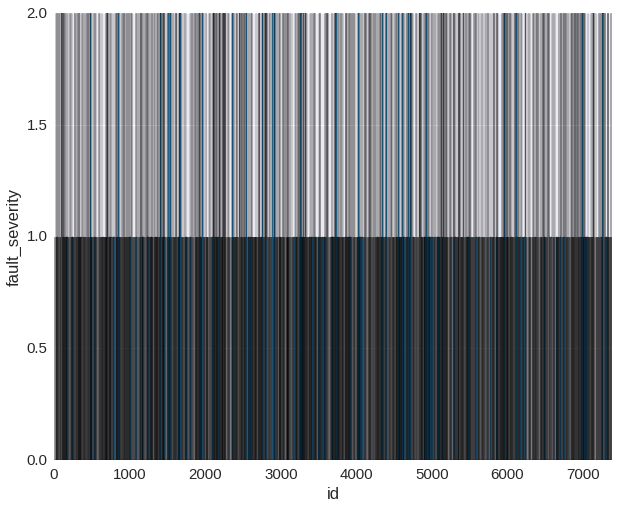

In [427]:
fault = df.fault_severity.astype(float)
plt.bar(np.arange(n), fault)
plt.show()

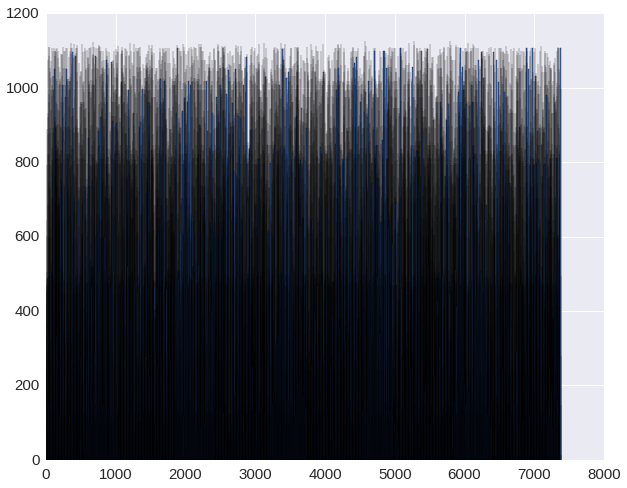

In [428]:
loc = df.location.astype(float)
plt.bar(np.arange(n), loc)
plt.show()

Both look like noise to me, gonna leave it for now. What about correlations among the various codes?

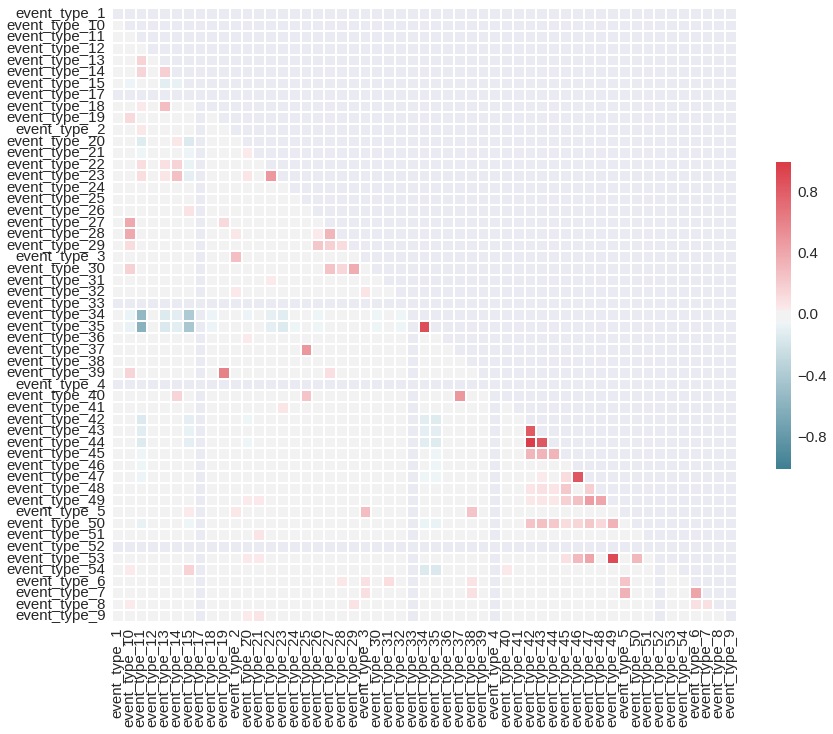

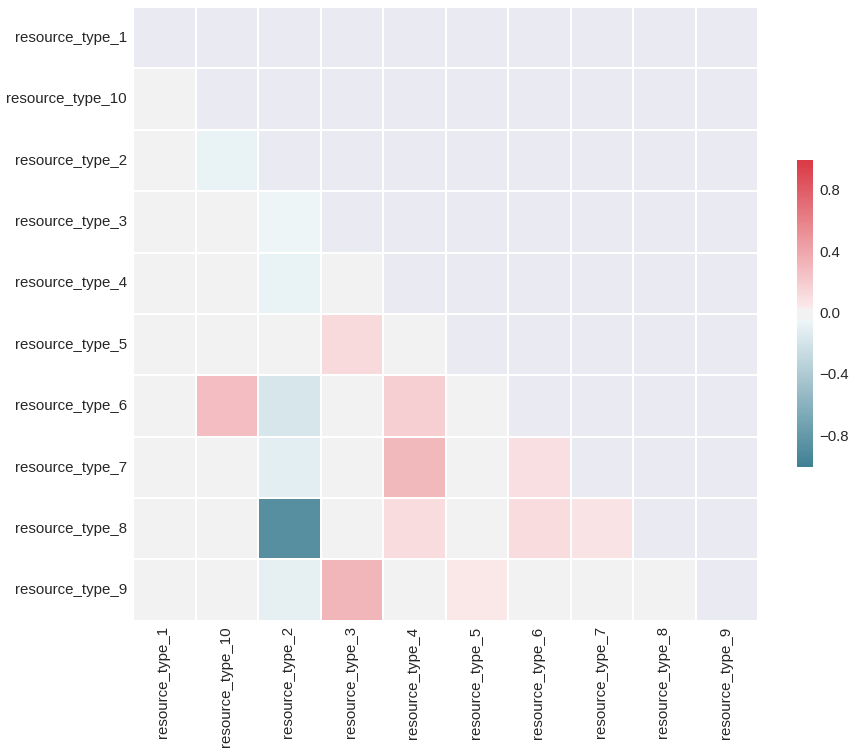

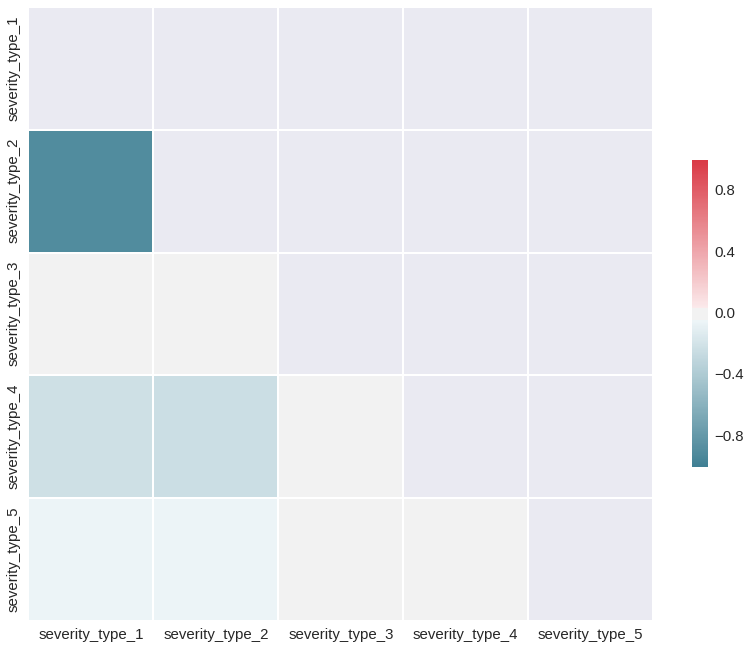

In [435]:
a = ['event_type', 'resource_type', 'severity_type']
for b in a:

    # Compute the correlation matrix
    corr = df.filter(regex=b).corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(14, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

The serverity codes look to be nicely anti-correlated as one would expect. There is also interesting structure in the resource and event types.

Makes me more curious about how these events are networked, i.e. communicating to each other? Build out as network problem? Can't: id and loc are 1:1 so the only connections will be among events that are the same, in that they have the same coding across all types. I don't see that as informative to a model.

However, clustering should be interesting: can add cluster membership as a new feature. Data is sparse matrix of binary and multiclass values, options for analysis:
* binary Jaccard similarity distance and [score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_similarity_score.html)
* K-mode clustering
* Cosine Distance (and other sparse text vectors)
* dissimilarity matrix

For k-means, see the odot ipynb, which isn't relevant here since this is categorical data (0/1) and Euclidean distance (used for clustering in k-menas) will be meaningless.

In [ ]:
X_km = df.as_matrix().astype(int)
km = kmodes.KModes(n_clusters=12, init='Cao', n_init=20, verbose=1)
clusters = km.fit_predict(X_km)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2820, cost: 41502.0
Run 1, iteration: 2/100, moves: 231, cost: 41235.0
Run 1, iteration: 3/100, moves: 98, cost: 40687.0
Run 1, iteration: 4/100, moves: 535, cost: 39553.0

# Algorithm Evaluation
## Experiments
Going to build test harness of test, train, and validation splits using KFolding. Then run predicitions for each fold. Also want to keep track of true positive rate (tpr) and false positive rate (fpr) so I can evaluate receiving operating characteristic curves (ROC's) and the associated area under the curve (AUC) of each. I will also plot the confusion matrix for each model to visualize the predicitve results.

want to try
xgboost
sklearn predict_proba

In [ ]:
# load scikit harness
from sklearn import metrics
from sklearn import decomposition
from sklearn import cluster
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV

In [ ]:
def run_cv(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=10, shuffle=True, random_state=4)
    y_pred = y.copy()
    mean_tpr = 0.0
    mean_acc = 0.0
    mean_prec = 0.0
    mean_recl = 0.0
    mean_f1 = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for train_index, test_index in kf:
        clf = clf_class(**kwargs)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y[test_index], y_pred[test_index])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        mean_acc += metrics.accuracy_score(y[test_index], y_pred[test_index])
        mean_recl += metrics.recall_score(y[test_index], y_pred[test_index])
        mean_prec += metrics.precision_score(y[test_index], y_pred[test_index])
        mean_f1 += metrics.f1_score(y[test_index], y_pred[test_index])
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    mean_acc /= len(kf)
    mean_recl /= len(kf)
    mean_prec /= len(kf)
    mean_f1 /= len(kf)
    return y_pred, mean_fpr, mean_tpr, mean_auc, mean_acc, mean_prec, mean_recl, mean_f1

def plot_roc(fpr, tpr, auc):
    plt.plot(fpr, tpr, 'k--',label='Mean ROC (area = %0.2f)' % auc, lw=2)
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

def draw_confusion_matrices(confusion_matrices, class_names):
    labels = list(class_names)
    for cm in confusion_matrices:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm[1])
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.title('%s' % cm[0])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        for i,j in ((x,y) for x in xrange(len(cm[1])) for y in xrange(len(cm[1][0]))):
            val = '{:.1%}'.format(cm[1][i][j]/cm[1].sum())
            ax.annotate(str(val), xy=(i,j), color='white', ha="center", va="center")
        plt.show()

Loading up a bunch of standard machine learning algorithms into test harness. This is a classification problem, so let's try the standard models...

        self._basicClf["Xgboost"] = self.getXgboostClf(X, Y)
        self._basicClf["Extra_Trees"] = self.getExtraTressClf(X, Y)
        self._basicClf["K_NN"] = self.getKnnClf(X, Y)
        self._basicClf["Naive_Bayes"] = self.getNaiveBayesClf(X, Y)
        from sklearn.tree import DecisionTreeClassifier
        from sklearn.ensemble import AdaBoostClassifier
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as ARF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import BernoulliRBM as RBM
from sklearn.tree import DecisionTreeClassifier as DT

# accuracy tests for some models
ml_models = []
ml_models.append(["Support Vector Machine", SVC, {}])
ml_models.append(["K-means Nearest Neighbor", KNN, {}])
ml_models.append(["Linear Logistic Regression", LR, {}])
ml_models.append(["Naive Bayes", NB, {}])
ml_models.append(["Decision Trees", DT, {}])
ml_models.append(["Random Forest", RF, {'n_estimators':200, 'random_state':123,
                                        'min_samples_split':2, 'n_jobs':-1}])
ml_models.append(["Ada Boosted RF", ARF, {'algorithm':'SAMME','n_estimators':200}])

# below model in scikit v0.18 only
#from sklearn.neural_network import MLPClasffifier as NNet
#ml_models.append(["Neural Network", NNet, {'algorithm':'l-bfgs', 'alpha':1e-5,
#                                           'hidden_layer_sizes':(5, 2), 'random_state':123}])

## Measure Performance

Show me the accuracy (acc), precision (prec), recall (recl), confusion matrix (cm), and mean auc for each model.

In [ ]:
# process each model
from scipy import interp
models = []
acc = []
prec = []
recl = []
f1 = []
cms = []
aucs = []
for m in ml_models:
    y_pred, mean_fpr, mean_tpr, mean_auc, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X, y, m[1], **m[2])
    models.append(m[0])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))
    aucs.append(mean_auc)
    plot_roc(mean_fpr, mean_tpr, mean_auc)

# plot confusion matricies
draw_confusion_matrices(cms, np.unique(y))

In [ ]:
models_df = pd.DataFrame.from_items([('model', models),
                              ('accuracy', acc),
                              ('precision', prec),
                              ('recall', recl),
                              ('f1', f1)
                              ])
models_df.sort(['accuracy', 'precision', 'recall', 'f1'], ascending=[False, False, False, False])

# Testing Results 

In [ ]:
# best and worst models
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])

max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])

max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

max_idx, max_value = max(enumerate(aucs), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best F1:', ml_models[max_idx][0], f1[max_idx])

Random forest is the obvious winner by all measures, so let's take a crack at tuning that model.

## Algorithm Tuning

### Question: What are the important features in the model, and does the model improve when using those features only?

In [ ]:
# feature importance
kf = KFold(len(y), n_folds=10, shuffle=True, random_state=4)
y_pred = y.copy()

# keep values for all features
feat_impt = {}
for f in features:
    feat_impt[f] = []

# go through all features    
for train_index, test_index in kf:
    clf = RF(n_estimators=50, min_samples_split=2, n_jobs=-1)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    y_pred[test_index] = clf.predict(X_test)
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    for f in range(X.shape[1]):
        feat_impt[features[indices[f]]].append(importances[indices[f]])

for k in feat_impt:
    val = np.mean(feat_impt[k])
    std = np.std(feat_impt[k])
    feat_impt[k] = val

In [ ]:
# sort the features by importance
sorted_feat = sorted(feat_impt.items(), key=operator.itemgetter(1))
sorted_feat.reverse()

# bookkeeping
cumper = 0.
nbr = False

# make a copy of original dataframe to drop unneeded features
X_keep = df

# print out importances
print "item -- feature -- weight -- cumm_weight"
for i, k in enumerate(sorted_feat):
    cumper += k[1]
    
    # tell me when we hit 90% of weights
    if (nbr is False and cumper >= 0.90):
        print '**----  Reached 90%  ----**'
        nbr = True
    print i, k[0], '{:.1%}'.format(k[1]), '{:.0%}'.format(cumper)
    
    # drop unneeded features
    if nbr is True:
        X_keep = X_keep.drop(k[0], axis=1)

Top 13 features account for 90% of the model weights. Let's try a RF with those features only.

In [ ]:
# get names of all features in new df
X_keep = X_keep.drop('churn', axis=1)
features_keep = X_keep.columns
X_keep = X_keep.as_matrix().astype(np.float)

# scale and/or transform X
scaler = StandardScaler()
X_keep = scaler.fit_transform(X_keep)

# checks
print "\n%d observations of %d features" % X_keep.shape
print "Unique labels:", np.unique(y)
print "Gut-check features: %i" % len(features_keep)
print "Gut-check mean: %.4f" % np.mean(X_keep[:,0])
print "Gut-check std: %.4f" % np.std(X_keep[:,0])

Re-run the ML test harness for RF only and see if the model improves (below is cut and paste of earlier code)

In [ ]:
ml_models = []
ml_models.append(["Random Forest", RF, {'n_estimators':200, 'random_state':123,
                                        'min_samples_split':2, 'n_jobs':-1}])
acc = []
prec = []
recl = []
f1 = []
cms = []
aucs = []
for m in ml_models:
    y_pred, mean_fpr, mean_tpr, mean_auc, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X_keep, y, m[1], **m[2])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))
    aucs.append(mean_auc)
    plot_roc(mean_fpr, mean_tpr, mean_auc)
draw_confusion_matrices(cms, np.unique(y))
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])
max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])
max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])
max_idx, max_value = max(enumerate(aucs), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best F1:', ml_models[max_idx][0], f1[max_idx])

* RF predictive power got worse when features contributing < 10% weight were dropped.
* RF predictive power got worse when features contributing < 5% weight were dropped.

**The RF model performs best when all features are included.**

### Question: But is RF superior in its calibration and discrimination?

Calibration measures the difference between actual and predicted probability for individual groups. Discrimination measures the difference between model predictions and the baseline probability. Equations are taken from [Yang, Yates, and Smith (1991)](http://psychology.huji.ac.il/.upload/Ilan/YanivYatesSmith1991PB.pdf).

In [ ]:
from operator import idiv

def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=10, shuffle=True)
    y_prob = np.zeros((len(y), 2))
    for train_index, test_index in kf:
        clf = clf_class(**kwargs)
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf.fit(X_train,y_train)
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

def calibration(prob, outcome,n_bins=10):
    prob = np.array(prob)
    outcome = np.array(outcome)
    c = 0.0
    judgement_bins = np.arange(n_bins + 1) / n_bins
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        predicted_prob = np.mean(prob[in_bin])
        true_bin_prob = np.mean(outcome[in_bin])
        c += np.sum(in_bin) * ((predicted_prob - true_bin_prob) ** 2)
    return c / len(prob)

def discrimination(prob, outcome, n_bins=10):
    prob = np.array(prob)
    outcome = np.array(outcome)
    d = 0.0
    base_prob = np.mean(outcome)
    judgement_bins = np.arange(n_bins + 1) / n_bins
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        true_bin_prob = np.mean(outcome[in_bin])
        d += np.sum(in_bin) * ((true_bin_prob - base_prob) ** 2)
    return d / len(prob)

In [ ]:
print "Lower calibration and higher discrimination are preferred..."

ml_models = []
ml_models.append(["Support Vector Machine", SVC, {'probability':True}])
ml_models.append(["K-means Nearest Neighbor", KNN, {}])
ml_models.append(["Linear Logistic Regression", LR, {}])
ml_models.append(["Naive Bayes", NB, {}])
ml_models.append(["Decision Trees", DT, {}])
ml_models.append(["Random Forest", RF, {'n_estimators':200, 'random_state':123,
                                        'min_samples_split':2, 'n_jobs':-1}])
ml_models.append(["Ada Boosted RF", ARF, {'algorithm':'SAMME','n_estimators':200}])

cal_err = []
discrim = []
for m in ml_models:
    print "\n"+m[0]
    pred_prob = run_prob_cv(X, y, m[1], **m[2])
    churn_prob, is_churn = pred_prob[:,1], y == 1
    cal_err.append(calibration(churn_prob, is_churn))
    discrim.append(discrimination(churn_prob,is_churn))
    print '{:20} {:.4f}'.format("Calibration Error", cal_err[-1])
    print '{:20} {:.4f}'.format("Discrimination", discrim[-1])
    
idx, value = min(enumerate(cal_err), key=operator.itemgetter(1))
print '{:20} {:20} {:.3%}'.format('\nBest calibration error:', ml_models[idx][0], cal_err[idx])
idx, value = max(enumerate(discrim), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best discrimination:', ml_models[idx][0], discrim[idx])

### Question: Can we tune the model params to get better results?

In [ ]:
from operator import itemgetter

def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [ ]:
from time import time
from sklearn.grid_search import GridSearchCV

clf = RF(n_jobs=-1)
param_grid = {"n_estimators":[500, 1000],
              "max_depth": [None, 3],
              "max_features": [None, 'auto'],
              "min_samples_split": [4],
              "min_samples_leaf": [1],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

**Best scores using X (took 542.40 seconds for 32 candidate parameter settings):**

Model with rank: 1
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.009)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.955 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}


**Best scores using X_keep (took 471.68 seconds for 48 candidate parameter settings):**

Model with rank: 1
Mean validation score: 0.957 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

In [ ]:
ml_models = []
ml_models.append(["Random Forest", RF, {'bootstrap': True,
                                        'min_samples_leaf': 1,
                                        'n_estimators': 500,
                                        'min_samples_split': 4,
                                        'criterion': 'entropy',
                                        'max_features': 'auto',
                                        'max_depth': None,
                                        'n_jobs': -1}])
acc = []
prec = []
recl = []
f1 = []
cms = []
aucs = []
for m in ml_models:
    y_pred, mean_fpr, mean_tpr, mean_auc, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X, y, m[1], **m[2])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))
    aucs.append(mean_auc)
    plot_roc(mean_fpr, mean_tpr, mean_auc)
draw_confusion_matrices(cms, np.unique(y))
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])
max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])
max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])
max_idx, max_value = max(enumerate(aucs), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best F1:', ml_models[max_idx][0], f1[max_idx])

**This model is hardly better than the initial guess, but it's technically simpler, so I'll run with this one.**

In [ ]:
# Use 10 estimators so predictions are all multiples of 0.1
m = (["Random Forest", RF, {'bootstrap': True,
                            'min_samples_leaf': 1,
                            'n_estimators': 10,
                            'min_samples_split': 1,
                            'criterion': 'entropy',
                            'max_features': 'auto',
                            'max_depth': None,
                            'n_jobs': -1}])
pred_prob = run_prob_cv(X, y, m[1], **m[2])
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

In [ ]:
from ggplot import *
baseline = np.mean(is_churn)
ggplot(counts, aes(x='pred_prob',y='true_prob',size='count')) + \
        geom_point(color='blue') + \
        stat_function(fun = lambda x: x, color='red') + \
        stat_function(fun = lambda x: baseline, color='green') + \
        xlim(-0.05,  1.05) + \
        ylim(-0.05,1.05) + \
        ggtitle("Random Forest") + \
        xlab("Predicted probability") + ylab("Relative frequency of outcome")

# -------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------
# Stuff below is collected junk that might be used.

In [ ]:
# build random forest
clf = RandomForestClassifier(n_estimators=50, oob_score=True)  
n_trials = 100
test_size_percent = 0.1

# build labels
sig_field = 'sms_count'
signals = df[[c for c in df.columns if c != sig_field]]
labels = df[sig_field]

# test train split
plot_data = []
for trial in range(n_trials):
    train_signals, test_signals, train_labels, test_labels = train_test_split(
                                                            signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:,1]
    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)  
    thresholds = np.append(thresholds, 1)
    queue_rate = []  
    for threshold in thresholds:  
        queue_rate.append((predictions >= threshold).mean())
        
    # save plot data
    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })
    
# plot model
uniform_thresholds = np.linspace(0, 1, 101)
uniform_precision_plots = []  
uniform_recall_plots= []  
uniform_queue_rate_plots= []
for p in plot_data:  
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])

    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

quantiles = [0.1, 0.5, 0.9]  
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)  
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)  
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_precision)  
plt.plot(uniform_thresholds, median_recall)  
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])  
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])  
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  

uniform_payout_plots = []
n = 10000  
success_payoff = 100  
case_cost = 20

for p in plot_data:  
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]
        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)
    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])  
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]  
plt.vlines([max_ap], -100000, 150000, linestyles='--')  
plt.ylim(-100000, 150000)

leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('$')  
plt.title("Payout as a Function of Threshold")

print '{0:.0f}'.format(np.max(median_payout))